# Decision Networks

In [1]:
using BayesNets
using DataFrames

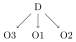

In [2]:
b = BayesNet()
push!(b, StaticCPD(:D, Bernoulli(0.01)))
push!(b, StaticCPD(:O1, [:D], Bernoulli(0.5))) # no real signal of whether disease is present
push!(b, FunctionalCPD{Bernoulli}(:O2, [:D], a->Bernoulli(a[:D] == true ? 0.9 : 0.01)))
push!(b, FunctionalCPD{Bernoulli}(:O3, [:D], a->Bernoulli(a[:D] == true ? 0.6 : 0.3)))

In [3]:
U = DataFrame()
U[:T] = [false, false, true, true]
U[:D] = [false, true, false, true]
U[:U] = [0, -10, -1, -1]
U

,T,D,U
1,false,false,0
2,false,true,-10
3,true,false,-1
4,true,true,-1


In [4]:
using Random
function estimate_table(b::BayesNet, target::NodeName, consistent_with::Assignment; nsamples = 10000)
    Random.seed!(0)
    t = fit(Table, rand(b, LikelihoodWeightedSampler(consistent_with), nsamples))
    normalize(sumout(t, setdiff(names(b), [target])))
end;

In [5]:
D = estimate_table(b, :D, Assignment(:O1=>true))

,D,p
1,0,0.9899
2,1,0.0101


In [6]:
EU = join(U, D.potential, on = :D)

,T,D,U,p
1,false,false,0,0.9899
2,false,true,-10,0.0101
3,true,false,-1,0.9899
4,true,true,-1,0.0101


In [7]:
using LinearAlgebra
by(EU, :T, df->LinearAlgebra.dot(df[:U], df[:p]))

,T,x1
1,false,-0.101
2,true,-1.0


In [8]:
function diseaseEU(b::BayesNet, a::Assignment, U::DataFrame)
    D = estimate_table(b, :D, a).potential
    EU = join(U, D, on = :D)
    t = by(EU, :T, df->LinearAlgebra.dot(df[:U], df[:p]))
    rename!(t, :x1=>:EU)
    t
end;

In [9]:
diseaseEU(b, Assignment(:O1=>true), U)

,T,EU
1,false,-0.101
2,true,-1.0


In [10]:
diseaseEU(b, Assignment(:O1=>false), U)

,T,EU
1,false,-0.101
2,true,-1.0


In [11]:
diseaseEU(b, Assignment(:O2=>true), U)

,T,EU
1,false,-4.78698
2,true,-1.0


In [12]:
diseaseEU(b, Assignment(:O3=>true), U)

,T,EU
1,false,-0.19998
2,true,-1.0
